# Preamble

## Imports

In [1]:
##ALL OF THE IMPORTS AND SUCH

import os
from concurrent.futures import ProcessPoolExecutor, as_completed


from LightPipes import *
from LightPipes import Field

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import math
import cmath
from numpy import genfromtxt
import colorcet as cc
import random
import aotools
import itertools
from tqdm import tqdm as progress
import random

import numpy as np
from numpy.linalg import eig,eigh
import scipy as sp

import pylab as pl

import numpy as np

# Parallelization Utilities
#from parallel_utils import init_worker, propagateSinglePixel_Optimized

# General Functions
from functions import ell, MUBphases, MixManyBeams, OAM, ANG, ArbMUB, Fqubit, wrap_to_pi

# Generating beam plots
from functions import plotBeam, plotBeamTransparent

# Overlap integrals and crosstalk
from functions import overlapInt, normTomography, crosstalkVecs, crosstalk, tomography, plotCrosstalk, beamsError

# Propagation
from functions import propChannel, propChannelSteps

# Parellelization of propagation of all pixels
from functions import propagateSinglePixel, parallelpropagatePixels

# Colours
from colours import colours
pmap, _, customColoursBGY, _ = colours()

#plt.style.use('dark_background')
plt.close('all')

## Crap for making videos - NOT IMPORTANT KEEP COMMENTED OUT but maybe we can put it in the functions

In [2]:
# plt.show(plotBeamTransparent(Fqubit(F,w,4,0,2,0)))

In [3]:
# N=128
# w=8.1*cm

# F=Begin(size=40*cm,labda=633*nm,N=N)
# #beamlist=[OAM(F,w,j) for j in ell(8)] + [ANG(F,w,8,j) for j in range(8)]
# d=4
# k,m=3,0

# beamlist=[Fqubit(F,w,d,j,k,m) for j in [0,1,2] for k in range(j+1,d) for m in range(d)]

# for i,phase in enumerate(np.arange(0,2*np.pi,np.pi/120)):
#     fig=plotBeamTransparent([SubPhase(beam,Phase(beam)+phase) for beam in beamlist],dpi=N,rows=2)
#     plt.savefig(f"figs/fqb/output{i:03d}.png",pad_inches=0,dpi=N)
#     plt.close(fig)


In [4]:
# import subprocess
# import os

# def create_transparent_webm(image_folder, output_name="beam_movie.webm", fps=120):
#     # Ensure filenames are sorted (e.g., output0.png, output1.png...)
#     # We use a text file list for FFmpeg to handle non-sequential naming
#     input_list = "images.txt"
#     filenames = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
    
#     with open(input_list, "w") as f:
#         for fname in filenames:
#             f.write(f"file '{os.path.join(image_folder, fname)}'\n")

#     # FFmpeg command for VP9 WebM with Alpha:
#     # -f concat: use the text file list
#     # -pix_fmt yuva420p: The 'a' stands for Alpha (transparency support)
#     # -auto-alt-ref 0: Required for transparency in some VP9 versions
#     cmd = [
#         'ffmpeg', '-y', 
#         '-r', str(fps), 
#         '-f', 'concat', '-safe', '0', '-i', input_list,
#         '-c:v', 'libvpx-vp9', 
#         '-pix_fmt', 'yuva420p', 
#         '-auto-alt-ref', '0', 
#         output_name
#     ]

#     try:
#         subprocess.run(cmd, check=True)
#         print(f"Successfully saved transparent video: {output_name}")
#     except subprocess.CalledProcessError as e:
#         print(f"Error running FFmpeg: {e}")
#     finally:
#         if os.path.exists(input_list):
#             os.remove(input_list)


In [5]:
# create_transparent_webm('figs/fqb', 'vids/fqb_02s.webm', fps=120)

# Channel Creation and Propagation

## Create Channel and Prop OAM

In [6]:
#Simulation Parameters
size = 40*cm
N = 64

lensSize=size/4 # Radius

#Beam Parameters
wavelength = 633*nm
w0=6.67/1.5*cm # Radius

#Propagataion Params
z=5000*m
numberOfPhaseScreens=3

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}

TurbStrength = 'MidWeakTurb'

r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
# Turbulence=2
# r0=size/Turbulence

phase_screen_seed=47

abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0,N,size/N,100,0.001) for i in range(numberOfPhaseScreens)]

#Default Beam
F=Begin(size,wavelength,N)

100%|██████████| 4/4 [00:00<00:00, 197.90it/s]


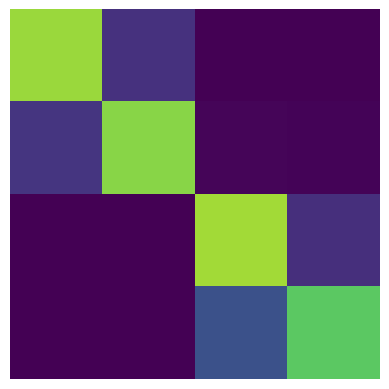

Error rate of 0.17910195895690073


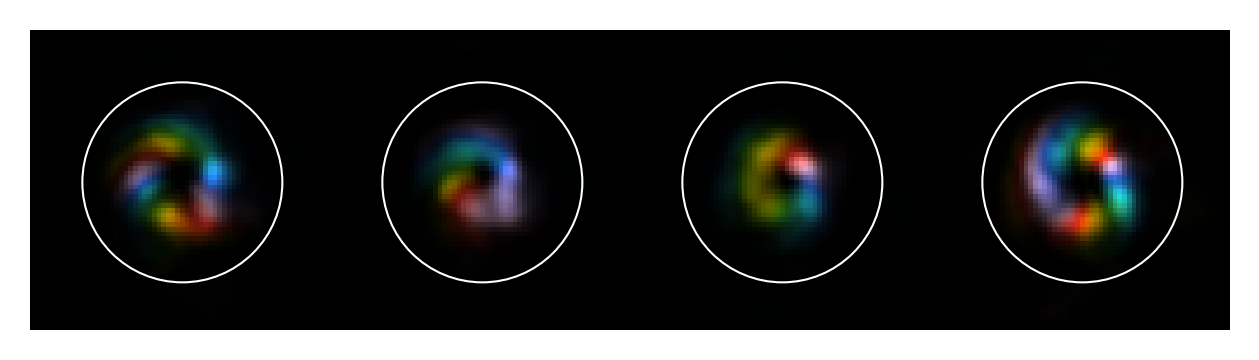

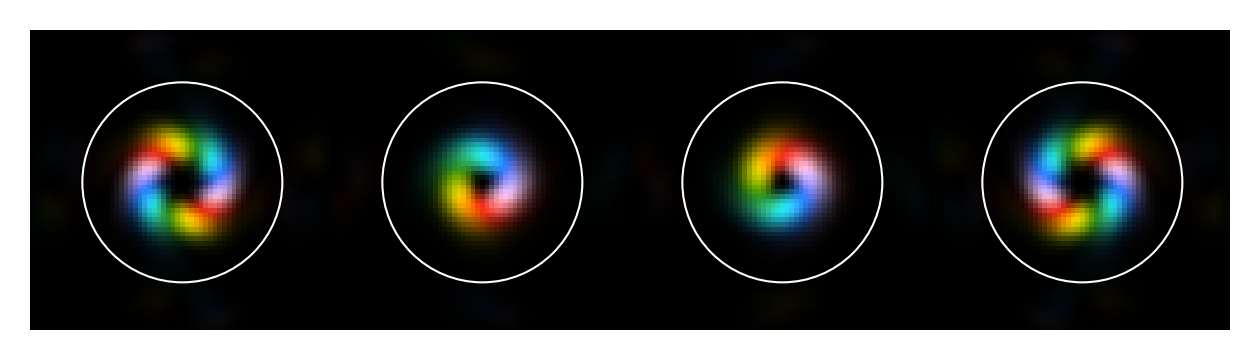

In [7]:
beams=[propChannel(OAM(F,w0,i),z,numberOfPhaseScreens,0) for i in progress(ell(4))]
errorBeams=[propChannel(OAM(F,w0,i),z,abbs) for i in progress(ell(4))]


plt.show(plotCrosstalk(crosstalk(beams,errorBeams)))
print(f'Error rate of {beamsError(beams,errorBeams)}')

plt.show(plotBeam(errorBeams,rows=1,aperature=size/3))
plt.show(plotBeam(beams,rows=1,aperature=size/3))

## Propagate a Singel Pixel with No Turbulence

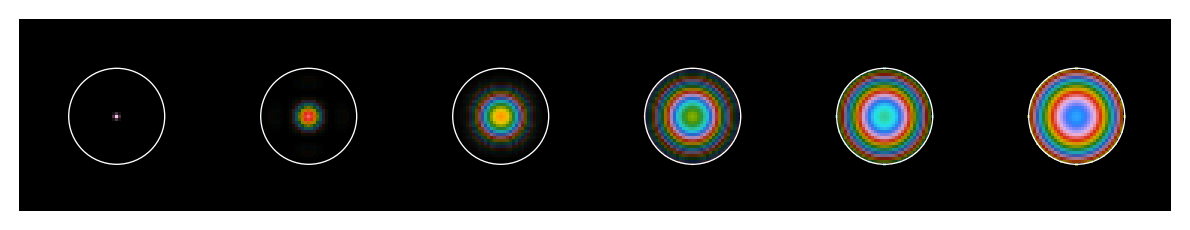

In [8]:
intens = np.zeros((N, N))
intens[N//2][N//2] = 1

#FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
#FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),FieldIn.siz/2), z, abbs)
F2 = [CircAperture(propChannel(CircAperture(SubPhase(SubIntensity(F, intens),np.zeros((N,N))),R=lensSize), dist),R=lensSize) for dist in [1,1000,2000,3000,4000,5000]]

plt.show(plotBeam(F2,aperature=lensSize,dpi=3*N))


## Propagate all Pixels

In [ ]:
if __name__ == "__main__":
    FieldsOut, endFields = parallelpropagatePixels(F, N, z, lensSize, abbs)
    print(f"Successfully processed {len(endFields)} pixels.")

Using 10 threads to propagate beams simulataneously...


Propagating invidual Pixels: 100%|██████████| 4096/4096 [00:05<00:00, 696.48it/s]

Successfully processed 4096 pixels.


## Infinite Phase Screen

### Kolmogerov statistics

In [10]:
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov
# Note that i set L0=75, if you try L0=100 you get some error at least for N=64. For N=64 we need L0<90 from my testing
# N=128 we need L0<41. Actually using L0=40 makes it look totally fucked lol. Even L0=30 is messed. Using L0=25 is nice... looks like using a small L0 with more resolution is the fix
L0 = N * size / N * 50
inf_ps = PhaseScreenKolmogorov(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0,random_seed=phase_screen_seed, stencil_length_factor=4)
inf_ps1 = inf_ps.scrn
inf_ps2 = PhaseScreenKolmogorov.get_new_row(inf_ps)

for i in range(0,int(N*10)):
    inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)

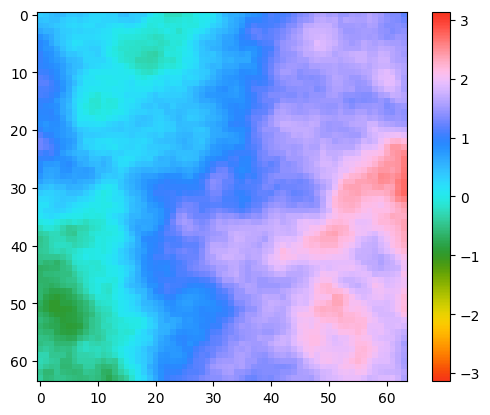

In [11]:
plt.imshow(wrap_to_pi(inf_ps1), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

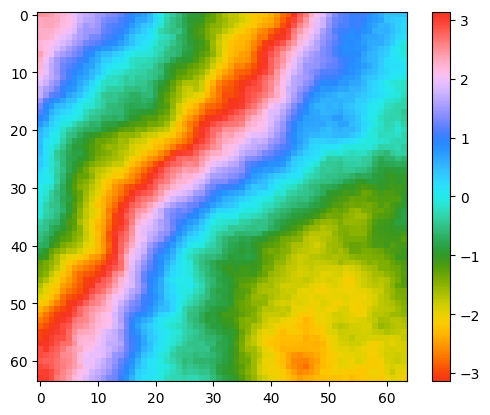

In [12]:
plt.imshow(wrap_to_pi(inf_ps3), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

### Von Karman statistics

In [13]:
# Infinite phase screens but with Von Karmon statistics

from aotools.turbulence.infinitephasescreen import PhaseScreenVonKarman
L0 = N * size / N * 50 # outer scale
inf_ps = PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0, random_seed=phase_screen_seed)
inf_ps1 = inf_ps.scrn

for i in range(0,int(N*10)):
    inf_ps2 = PhaseScreenVonKarman.add_row(inf_ps)

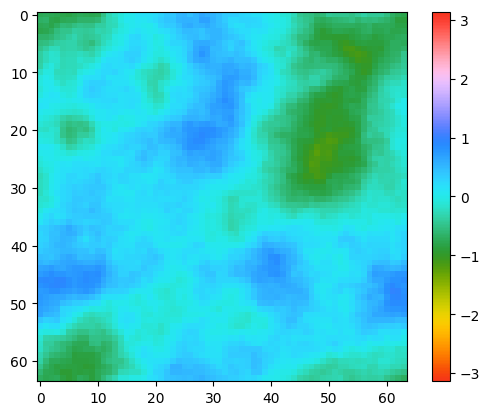

In [14]:
plt.imshow(wrap_to_pi(inf_ps1), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

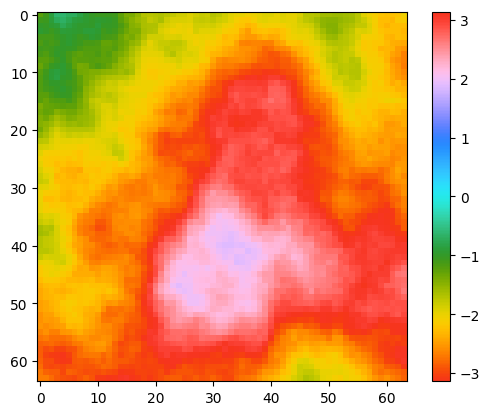

In [15]:
plt.imshow(wrap_to_pi(inf_ps2), cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [16]:
# PSUEDO CODE for adding phase screens incrementally and propagating a beam through them

# beam=OAM(F,w0+w0/2,0)
# plt.show(plotBeam(beam))

# for i in range(0,int(N/1.5)):

#     inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)
    
#     plt.savefig(plotBeam(propChannel(beam,z,abbs)))

## Saving images

### Saving images of gaussian beam after propagating

In [17]:
# Create folder first
os.makedirs("images/gaussian_prop", exist_ok=True)

#Default Beam
F=Begin(size,wavelength,N)

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}
TurbStrength = 'MidWeakTurb'
r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
numberOfPhaseScreens=3
L0 = N * size / N * 50 # outer scale

# Create phase screens
abbs=[PhaseScreenVonKarman(nx_size=N, pixel_scale=size/N, r0=r0, L0=L0) for i in range(numberOfPhaseScreens)]

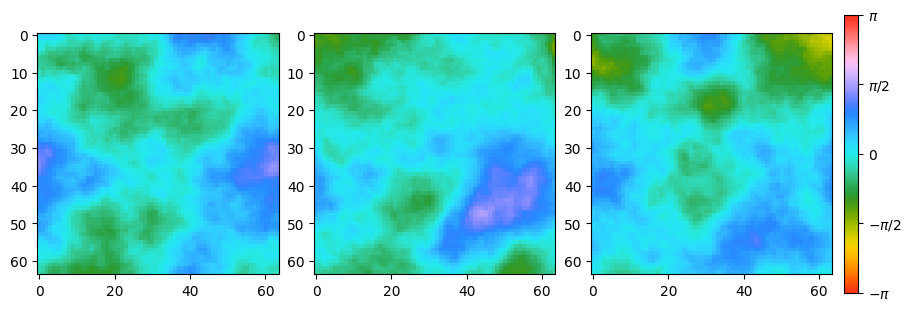

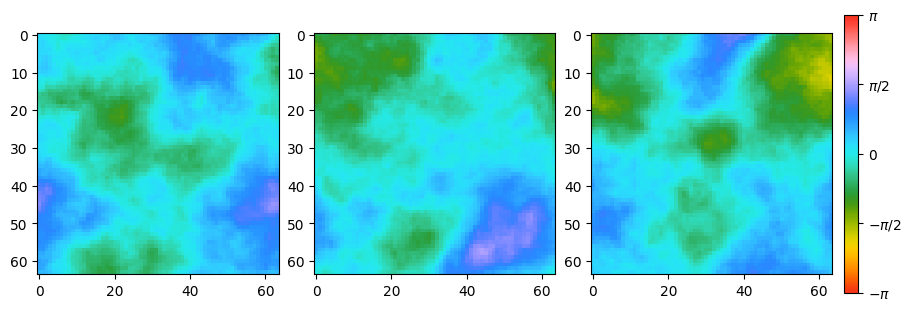

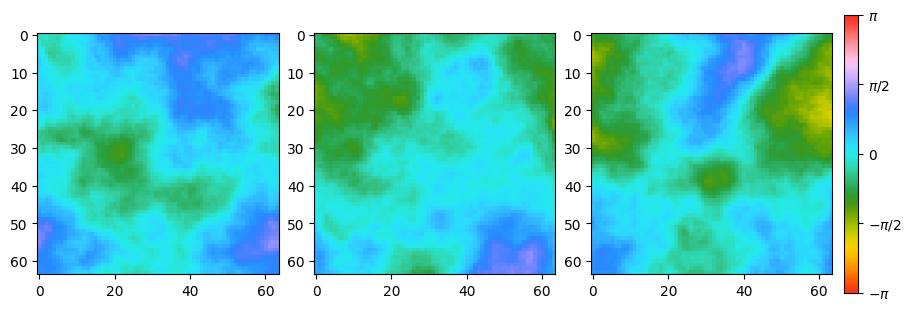

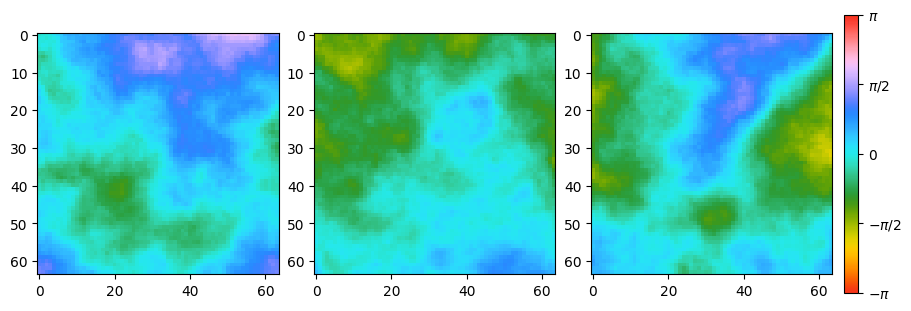

In [18]:
errorBeams=[]
numberOfFluctuations = 3
shift = 10 # How many rows to add with every fluctuation
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]

for i in range(numberOfFluctuations+1):
    for l in range(0, shift):
        abbs_fluctuation = [PhaseScreenVonKarman.add_row(abbs[j]) for j in range(numberOfPhaseScreens)]
    # Plot phase screens
    fig = plt.figure(i+1, figsize=(9,3), constrained_layout=True)
    axes=[]
    images=[]
    for j in range(numberOfPhaseScreens):
        ax = fig.add_subplot(1,3,j+1)
        im = ax.imshow(wrap_to_pi(abbs_fluctuation[j]), cmap=pmap, vmin=-np.pi, vmax=np.pi)
        axes.append(ax)
        images.append(im)
    cbar = fig.colorbar(im)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
    errorBeams.append(propChannel(OAM(F,w0,0),z,abbs_fluctuation))

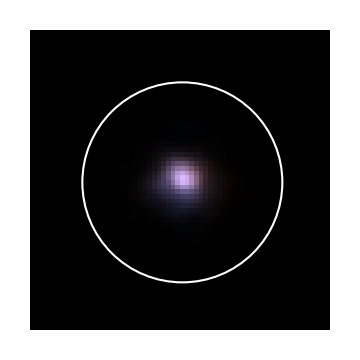

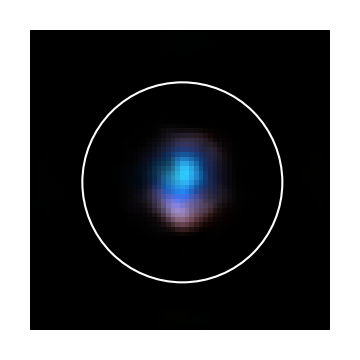

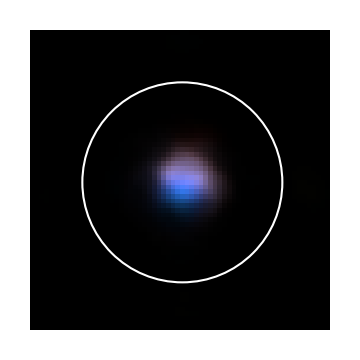

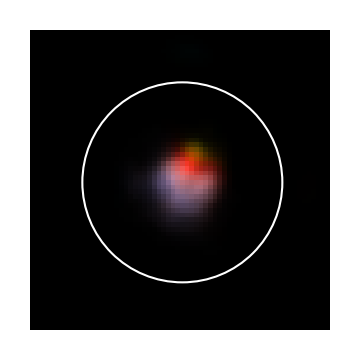

In [19]:
for i,Beam in enumerate(errorBeams):
    plotBeam(Beam, rows=1, aperature=size/3)
    plt.savefig(
        f"images/gaussian_prop/step_{i}.png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0
    )
    plt.show()
    plt.close()

# Calculate EigenModes

## Calculate eigenvalues and eigenvectors

In [25]:
transferMatrix=endFields

transferMatrixT=endFields.T

transferMatrixH=endFields.T.conj()

transferMatrixHermitian=transferMatrixH@transferMatrix

eigVals,eigVecs=np.linalg.eig(transferMatrixT)

#Get the absolute values and phases of the eigenvalues
eigMags=abs(eigVals)

In [26]:
# Sort the Eigenvalues by the magnitudes
sort_indices = np.argsort(eigMags)[::-1]
eigMags = eigMags[sort_indices]
eigVals = eigVals[sort_indices]
eigVecs = eigVecs[:, sort_indices]

## Plot Eigenvalues

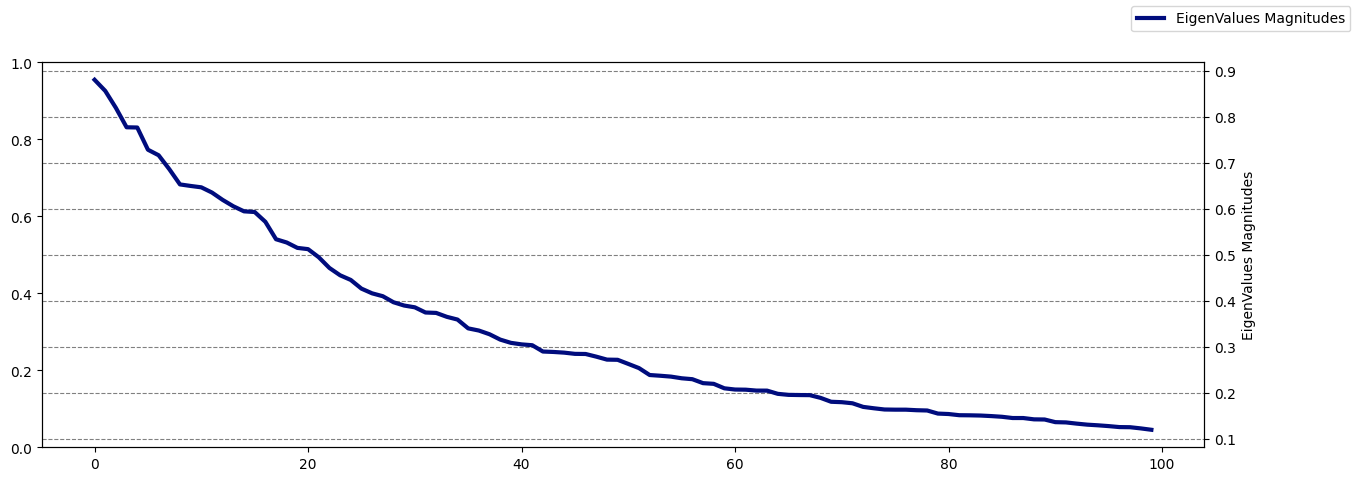

In [27]:
# Plot the eigenvalues

fig, ax1 = plt.subplots()
fig.set_size_inches(15,5)
x=range(0,len(eigMags))
ax2 = ax1.twinx()
ax2.yaxis.grid(True)
ax2.grid(visible=True,which='major',axis='both',color='gray',linestyle='--')
#ax1.set_ylabel('EigenValues Phases')
ax2.set_ylabel('EigenValues Magnitudes')

ax2.plot(x[:100],eigMags[:100],label='EigenValues Magnitudes',color=customColoursBGY[0],linewidth=3)

fig.legend()
plt.show()

## Create Optical Modes

In [28]:
#Making Eigenvector optical modes
F=Begin(size,wavelength,N)
eigenBeams=[]
for i in progress(range(100)):
    mode=eigVecs[:,i]
    eigenInt=[abs(val)**2 for val in mode]
    eigenInt=np.pad(np.array(eigenInt).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    eigenPhase=[cmath.phase(val) for val in mode]
    eigenPhase=np.pad(np.array(eigenPhase).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    F=SubPhase(SubIntensity(F,eigenInt),eigenPhase)
    eigenBeams.append(F)

eigenBeamPropagated=[propChannel(beam,z,abbs) for beam in progress(eigenBeams)]


100%|██████████| 100/100 [00:00<00:00, 323.77it/s]


### Normalize phase for plotting

In [29]:
############################
####
####
#### Need to normalize the phase on the propagated eigenmode to be able 
####    to display them next to one another and have consistent phase profiles.
####
############################

In [30]:
# Loop through eigenbeams and find position with max intensity and then find the phase there. Then find the difference in phase in the
# same position after propagating and subtract the entire array after propagating by this phase difference

for i, eigenBeam in enumerate(eigenBeams):
    intensity = Intensity(eigenBeam,1)
    max_pos = np.unravel_index(intensity.argmax(), intensity.shape)
    phase_diff = np.mod(Phase(eigenBeamPropagated[i]), 2*np.pi)[max_pos] - np.mod(Phase(eigenBeam), 2*np.pi)[max_pos]
    eigenBeamPropagated[i].field *= np.exp(1j * (-phase_diff)) # Subtract phase difference

## Plot Optical Modes

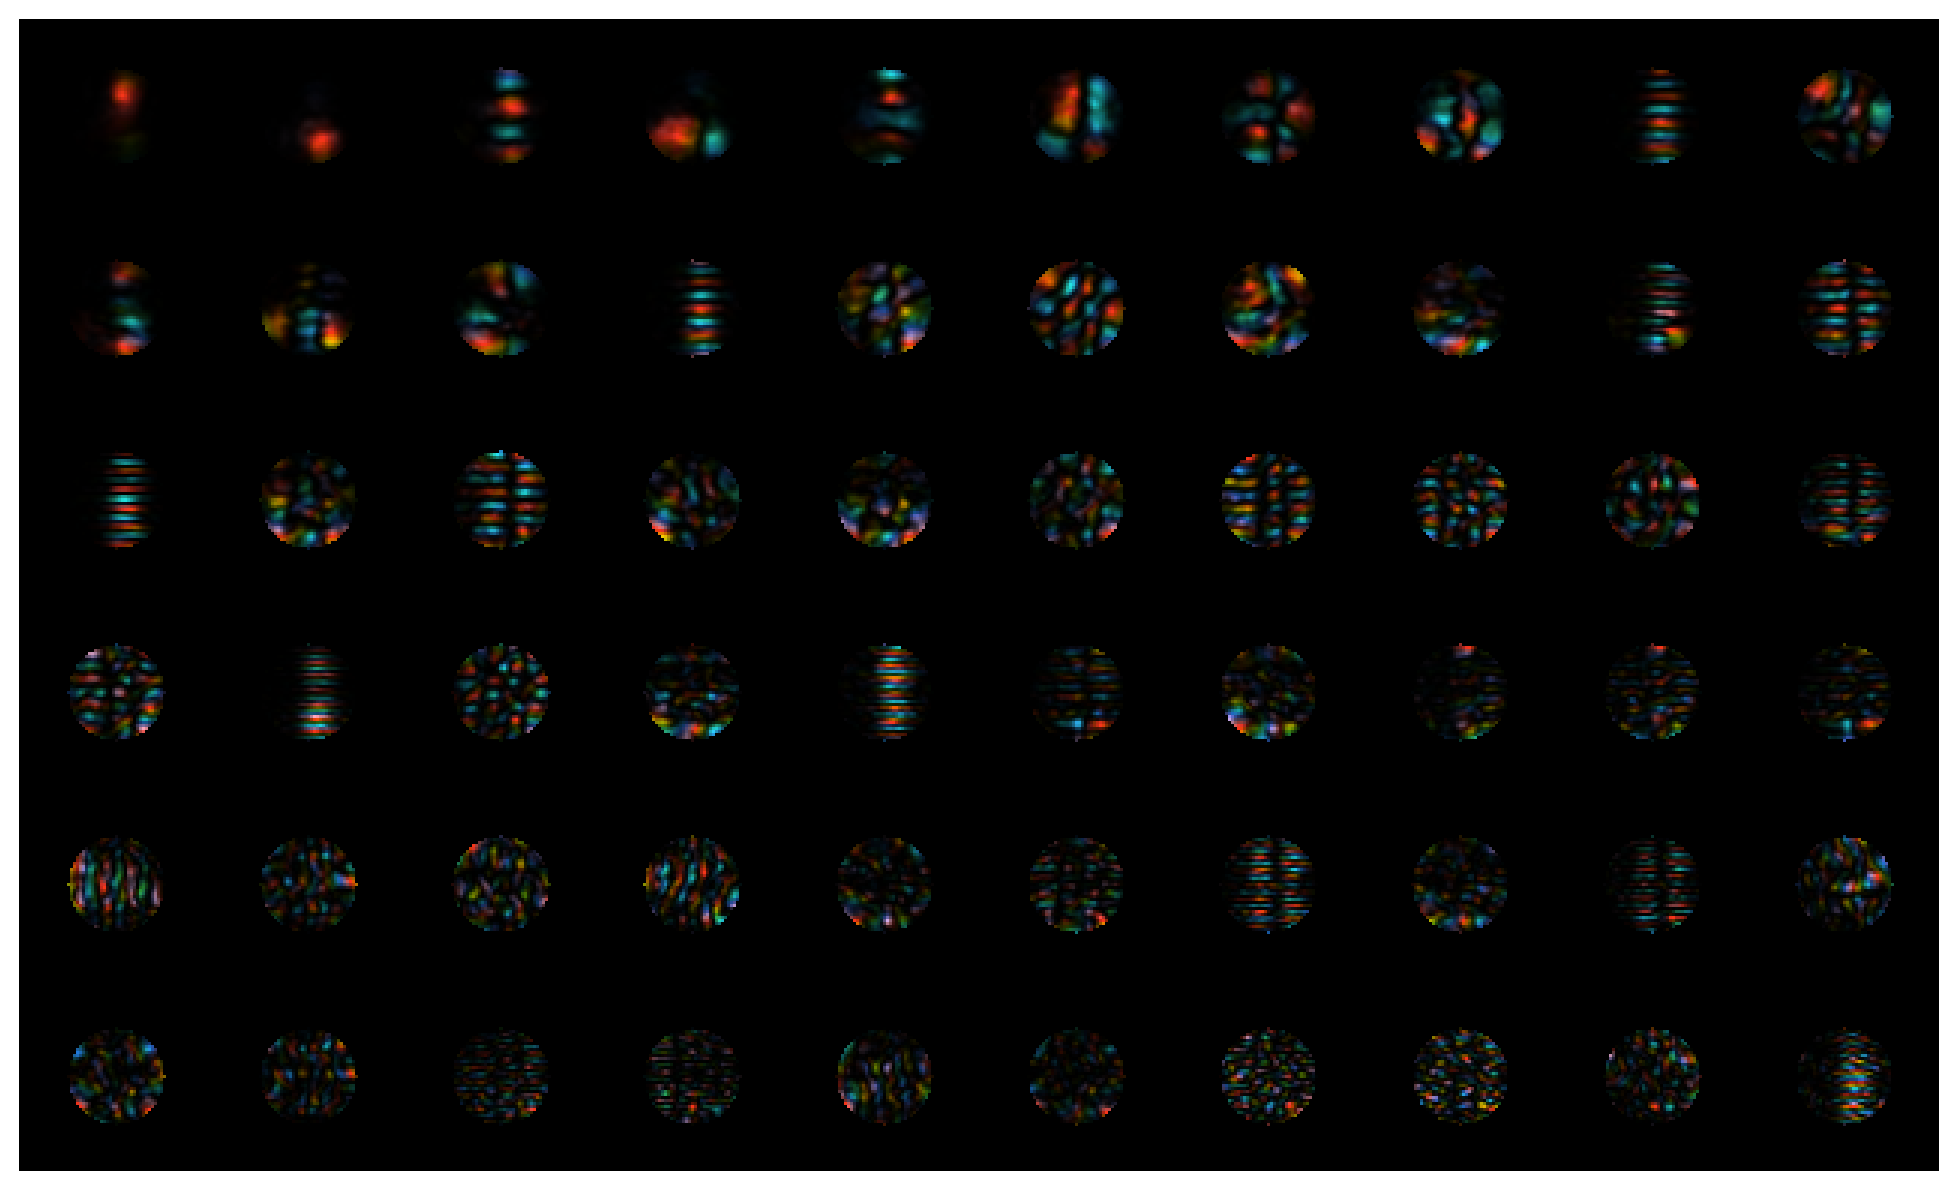

In [31]:
plot=plotBeam(eigenBeams[:60],rows=6,dpi=N*3)
plt.show();plt.close()

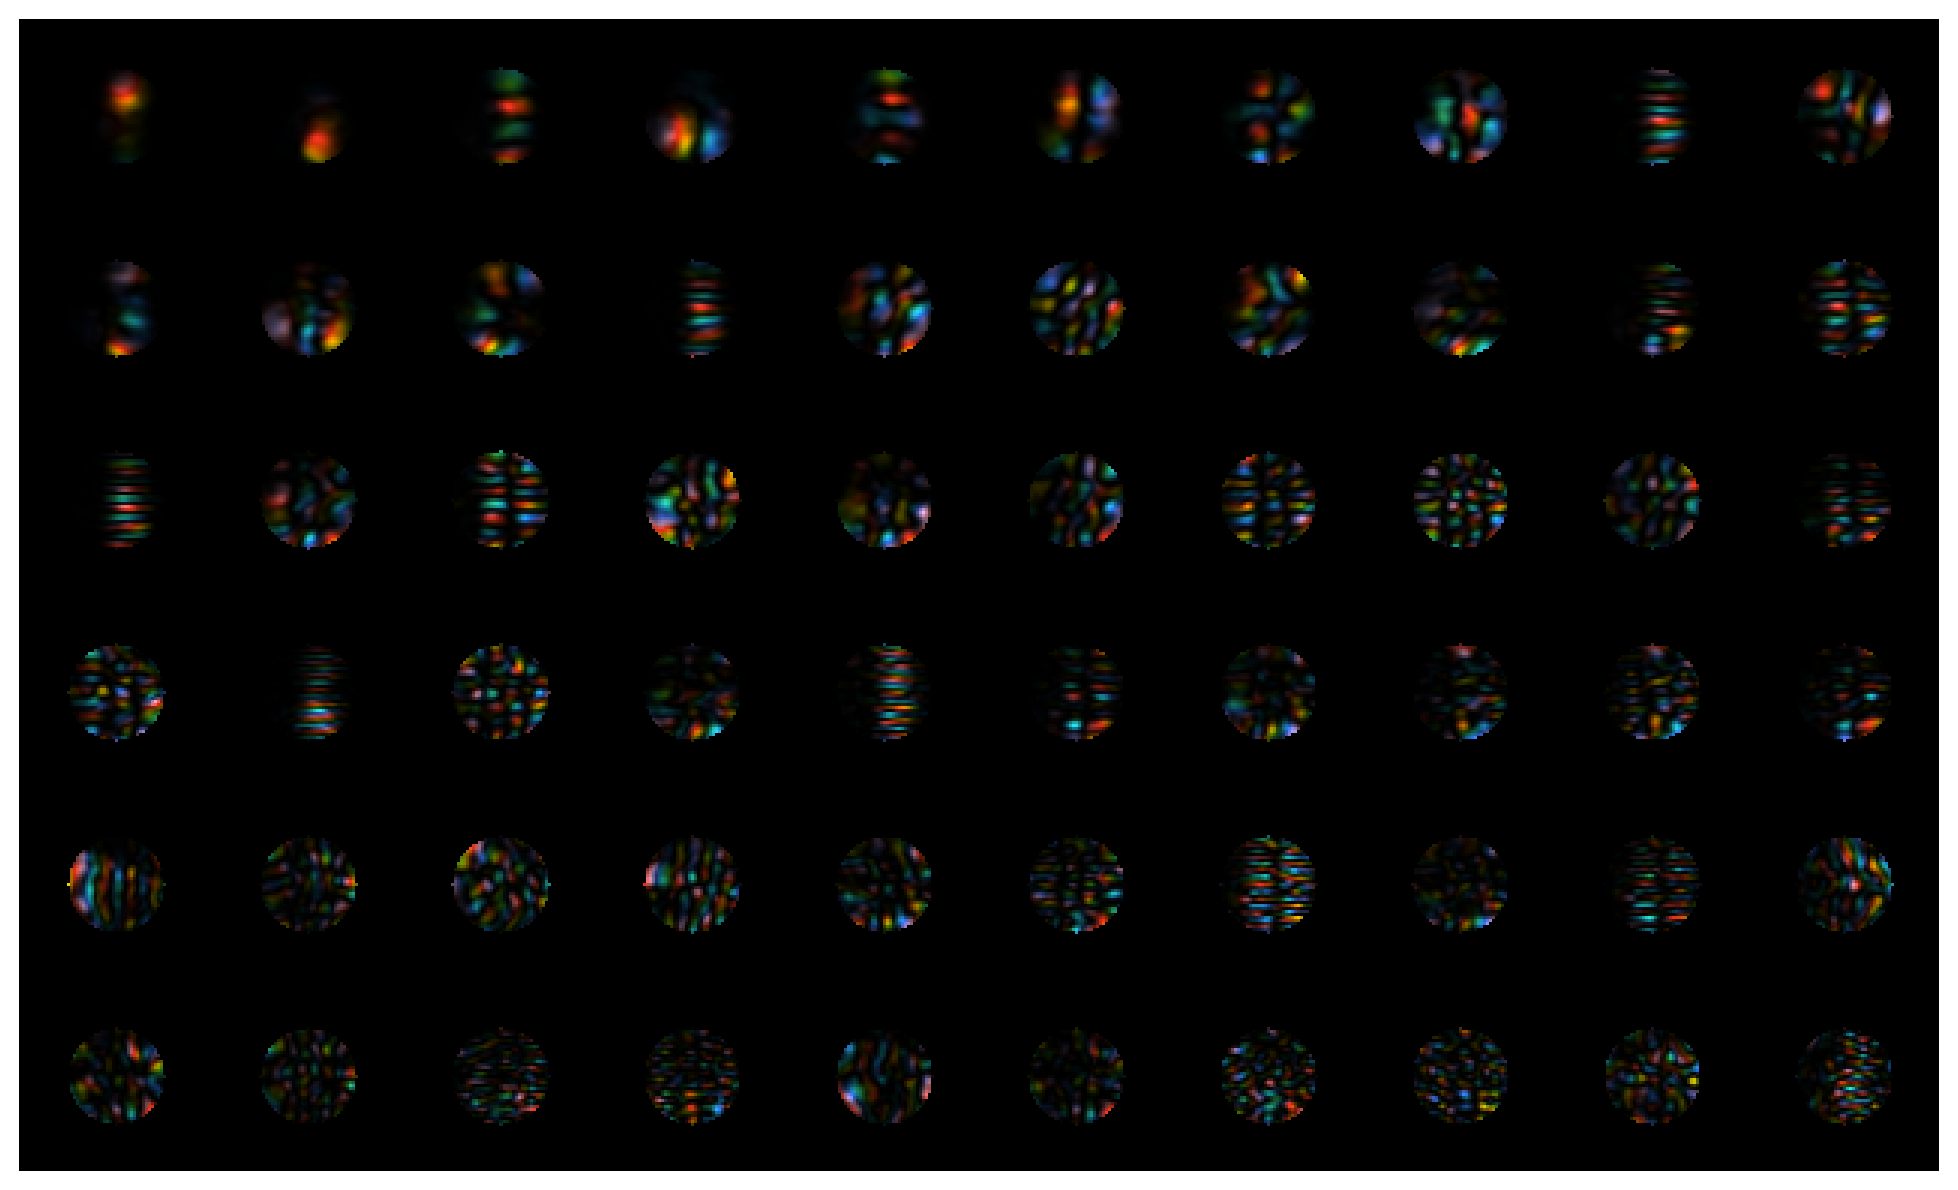

In [32]:
plot=plotBeam([CircAperture(beam,R=lensSize) for beam in eigenBeamPropagated[:60]],rows=6,dpi=N*3)
plt.show();plt.close()

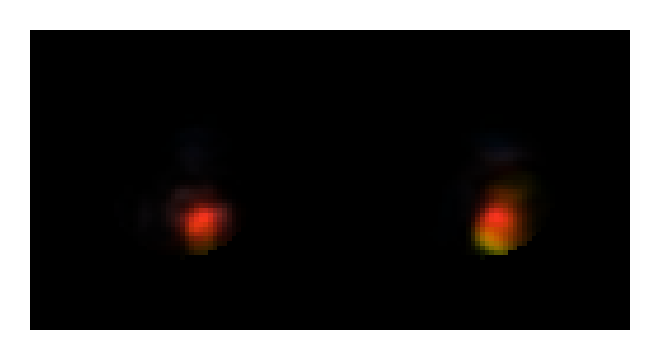

In [33]:
plt.show(plotBeam([eigenBeams[1],CircAperture(eigenBeamPropagated[1],R=lensSize)]))

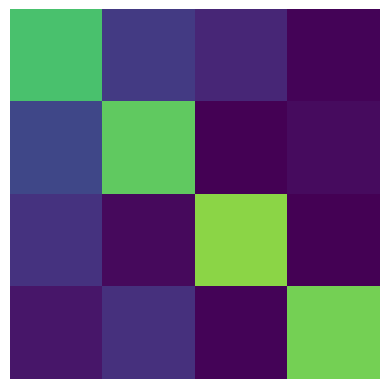

Error rate of 0.2286540138283495 when doing a measurement in the unpropagated Eigenmode basis


In [34]:
modeNumber=4

bestEigenBeams=eigenBeams[:modeNumber]
bestEigenBeamsPropagated=eigenBeamPropagated[:modeNumber]


plt.show(plotCrosstalk(crosstalk(bestEigenBeams,bestEigenBeamsPropagated)))
print(f'Error rate of {beamsError(bestEigenBeams,bestEigenBeamsPropagated)} when doing a measurement in the unpropagated Eigenmode basis')